# Import librarys

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.models import Model

In [3]:
# Test on which version
print(tf.__version__)

2.0.0


## MNIST Dataset

In [4]:
mnist = tf.keras.datasets.mnist
(input_train, output_train), (input_test, output_test) = mnist.load_data()

# 他的值是 0 ~ 255
input_train = input_train / 255
input_test = input_test / 255

print("Training input size shape: ", input_train.shape, input_train.dtype)
print("Training output size shape: ", output_train.shape, output_train.dtype)
print("Testing input size shape: ", input_test.shape, input_test.dtype)
print("Testing output size shape: ", output_test.shape, output_test.dtype)

Training input size shape:  (60000, 28, 28) float64
Training output size shape:  (60000,) uint8
Testing input size shape:  (10000, 28, 28) float64
Testing output size shape:  (10000,) uint8


In [5]:
img_w = input_train.shape[1]
img_h = input_train.shape[2]
img_shape = (img_w, img_h)

# Helper Function

In [6]:
# 一般的顯示結果
def plot_images(images, true_value, pred_value=None):
    assert len(images) == len(true_value) == 9
    
    # 3 x 3
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3) # 間隔
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if pred_value is None:
            xlabel = "True: {0}".format(true_value[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(true_value[i], pred_value[i])

        ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])
    
    # 顯示結果
    plt.show()

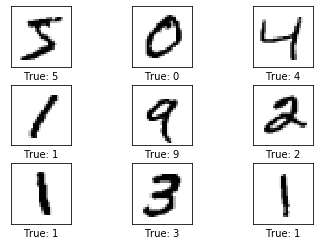

In [7]:
# Test
plot_images(input_train[0:9], output_train[0:9])

In [8]:
# 顯示錯誤的結果 (主要是針對 test 的結果)
def plot_error_images(pred_value):
#     incorrect = np.not_equal(pred_value, output_test)
    incorrect = pred_value != output_test
#     np.not_equal()
#     print(type(pred_value))
#     print(type(output_test))
#     print(np.array(pred_value) != np.array(output_test))
    
    # 拿出圖片
    imgs = input_test[incorrect][:9]
    correct_value = output_test[incorrect][:9]
    pred_part_value = pred_value[incorrect][:9]
    
    plot_images(imgs, correct_value, pred_part_value)

# Neural Network
---
這邊有兩個方法：
1. Sequential Model [Link](https://www.tensorflow.org/tutorials/keras/classification#set_up_the_layers)
這種方式有個缺點，就是如果 Model 很複雜(例如有分支)，那不用 sequential 來處理
2. Functional Model [Link](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/03C_Keras_API.ipynb)
這種方式即使有分支有可以實現，以下會用此方式來實作

In [9]:
net = Input(shape=(img_shape))
netInput = net

# 因為 他要 None, img_h, img_w, 1 => 4個 dims
net = Reshape((img_h, img_w, 1), name="Reshape")(net)

# layer1
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same', activation='relu', name='layer1_conv')(net)
net = MaxPool2D(pool_size=2, strides=2, name='layer1_maxpool')(net)

# layer2
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same', activation='relu', name='layer2_conv')(net)
net = MaxPool2D(pool_size=2, strides=2, name='layer2_maxpool')(net)

# 攤平
net = Flatten(name='Flatten')(net)

# Dense
net = Dense(128, activation='relu', name='Dense1')(net)
net = Dense(10, activation='softmax')(net)
netOutput = net

# Train
---

## 說明
如果是原先的資料

|         Predict        | GroundTrue |
|:----------------------:|:----------:|
|  [0.2, 0.1, 0.5, 0.2]  |      2     |
|    [0, 0.2, 0, 0.8]    |      3     |
| [0.7, 0.2, 0.05, 0.05] |      0     |

上面那種要使用 SparseCategoricalCrossentropy => 尤其是 integer

|         Predict        | GroundTrue (One Hot) |
|:----------------------:|:--------------------:|
|  [0.2, 0.1, 0.5, 0.2]  |     [0, 0, 1, 0]     |
|    [0, 0.2, 0, 0.8]    |     [0, 0, 0, 1]     |
| [0.7, 0.2, 0.05, 0.05] |     [1, 0, 0, 0]     |
上面那種要使用 CategoricalCrossentropy => 尤其是 One Hot encoding

In [10]:
model = Model(inputs=netInput, outputs=netOutput)
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [11]:
logdir = os.path.join("logs")

if not os.path.exists(logdir):
    os.mkdir(logdir)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [12]:
model.fit(x=input_train, y=output_train, epochs=10, batch_size=128, callbacks=[tb_callback])

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2049 - sparse_categorical_accuracy: 0.9394
Epoch 2/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0546 - sparse_categorical_accuracy: 0.9833
Epoch 3/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0379 - sparse_categorical_accuracy: 0.9885
Epoch 4/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0295 - sparse_categorical_accuracy: 0.9907
Epoch 5/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0227 - sparse_categorical_accuracy: 0.9930
Epoch 6/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0192 - sparse_categorical_accuracy: 0.9940
Epoch 7/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0161 - sparse_categorical_accuracy: 0.9946
Epoch 8/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0136 - spars

# 測試

In [13]:
result = model.evaluate(x=input_test, 
                        y=output_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [14]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.02750092268511833
sparse_categorical_accuracy 0.9916


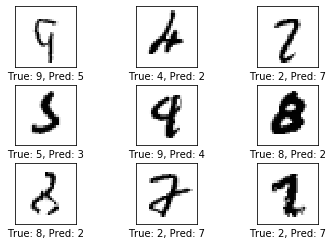

In [15]:
pred_test = model.predict(input_test) 
plot_error_images(np.argmax(pred_test, axis=1))